# Temporature forecast

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read in the dataset

In [2]:
dataset = pd.read_csv('temp.csv')
print(dataset.columns)
dataset.head()

Index(['Year', 'Month', 'Day', 'Date', 'PPT. ', 'Av temp', 'Tmax', 'Tmin'], dtype='object')


,Year,Month,Day,Date,PPT.,Av temp,Tmax,Tmin
0,1901,1,1,01/01/1901,0.0,2.1,3.5,0.6
1,1901,1,2,02/01/1901,0.0,4.0,7.2,0.7
2,1901,1,3,03/01/1901,0.0,3.0,6.7,-0.7
3,1901,1,4,04/01/1901,0.0,3.7,7.9,-0.6
4,1901,1,5,05/01/1901,0.0,-0.3,1.2,-1.7


数据表中：
- Year, Month, Day, Date 分别表示的具体的时间
- PPT. 表示日降水量
- Av temp 表示日平均气温
- Tmax 表示日最高气温 
- Tmin 表示日最低气温

In [ ]:
# 统计指标
print('数据维度:', dataset.shape)
dataset.describe()

In [3]:
# 数据清洗，Date、Tmax、Tmin与target无关
dataset = dataset.drop(columns='Date')
dataset = dataset.drop(columns='Tmax')
dataset = dataset.drop(columns='Tmin')

In [ ]:
# 通过1901年的数据，判断PPT和AvTemp的关系
sns.pairplot(dataset[:365])

In [4]:
# 通过对比图发现，PPT与AvTemp并无关系，可以直接删除
dataset = dataset.drop(columns='PPT. ')

In [9]:
dataset.head()

,Year,Month,Day,Av temp
0,1901,1,1,2.1
1,1901,1,2,4.0
2,1901,1,3,3.0
3,1901,1,4,3.7
4,1901,1,5,-0.3


## 思路：

1. 用Prophet包进行以下预测（ https://cloud.tencent.com/developer/article/1778307 ）
2. 手动进行数据分析（ https://zhuanlan.zhihu.com/p/206798885 ）
3. 利用神经网络进行分析（ https://blog.csdn.net/weixin_43918046/article/details/109496406 ）

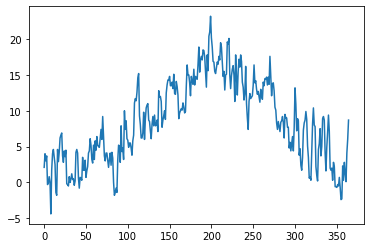

In [8]:
y1901 = dataset[:365]
plt.plot(y1901['Av temp'], label='Av Temp')
plt.show()

In [19]:
def runnian(year):
    flag = False
    if year%4 == 0 and year%100 != 0:
        flag = True
    return flag

def date2index(year, month, day):
    normal = [31,28,31,30,31,30,31,31,30,31,30,31]
    special = [31,29,31,30,31,30,31,31,30,31,30,31]
    if month == 1:
        return int(day - 1)
    else:
        if runnian(year):
            return int(sum(special[0:month-1]) + day - 1)
        else:
            return int(sum(normal[0:month-1]) + day - 1)

### 1 Prophet 方法



In [5]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
# years = dataset['Year']
# months = dataset['Month']
# days = dataset['Day']
dates = [str(year) + '-' + str(month) + '-' + str(day) for year, month, day in zip(dataset['Year'], dataset['Month'], dataset['Day'])]
dates = pd.to_datetime(dates)
temps = dataset['Av temp']

In [ ]:
df = pd.DataFrame({'ds': dates, 'y': temps})
pp_model = Prophet().fit(df)

In [8]:
future_temps = pp_model.make_future_dataframe(periods=366)
forecast = pp_model.predict(future_temps)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43825,2020-12-27,4.615207,0.905419,8.072154
43826,2020-12-28,4.583787,1.192748,7.954696
43827,2020-12-29,4.524397,1.202592,8.068880
43828,2020-12-30,4.463500,1.000933,7.834239
43829,2020-12-31,4.457425,1.165039,7.852761


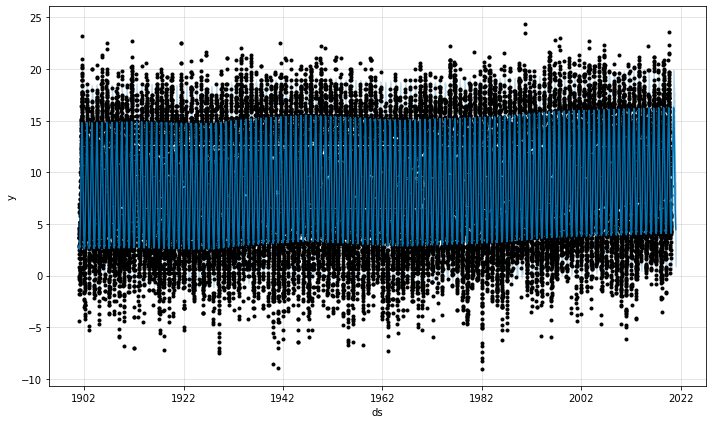

In [17]:
fig1 = pp_model.plot(forecast)

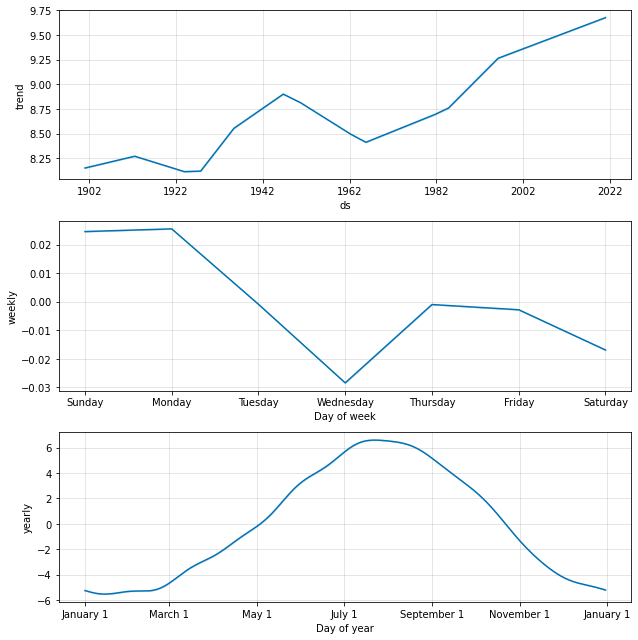

In [18]:
fig2 = pp_model.plot_components(forecast)

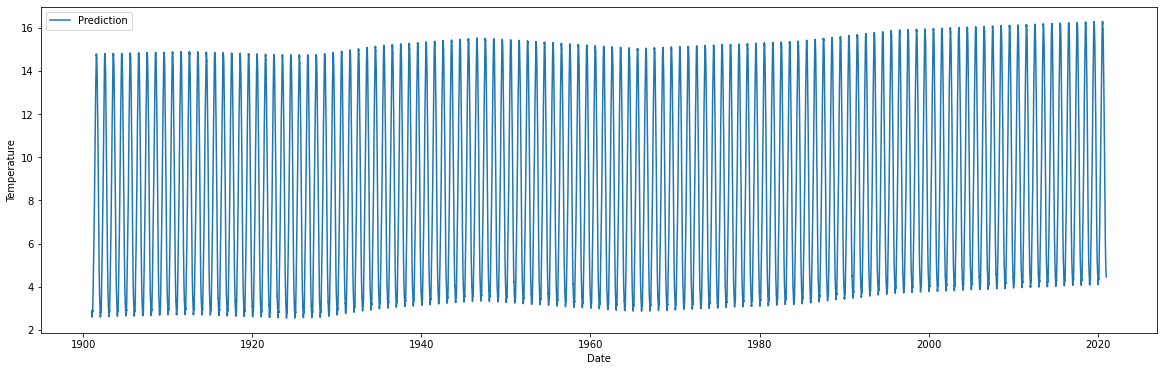

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

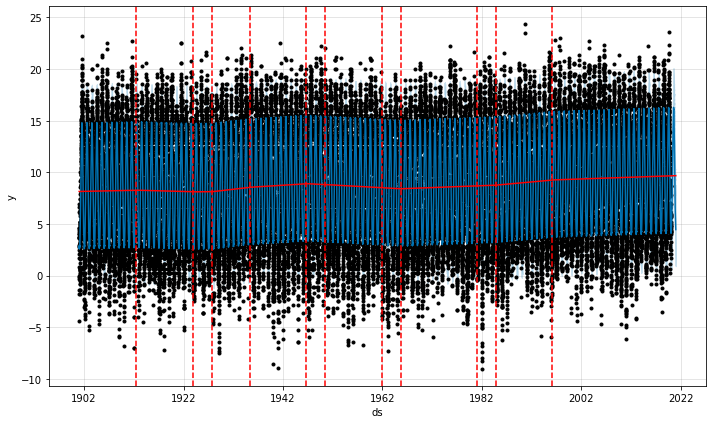

In [15]:
from prophet.plot import add_changepoints_to_plot
fig = pp_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pp_model, forecast)

### 2 手动分析